# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## План работы:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Метрика качества
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

## Метрика sMAPE вычисляется так: 
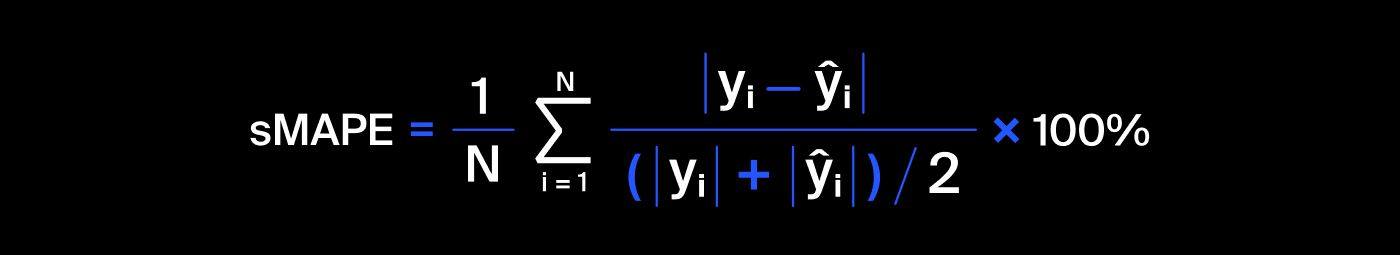

## Нужно спрогнозировать сразу две величины:

эффективность обогащения чернового концентрата rougher.output.recovery;
эффективность обогащения финального концентрата final.output.recovery.
## Итоговая метрика складывается из двух величин: 
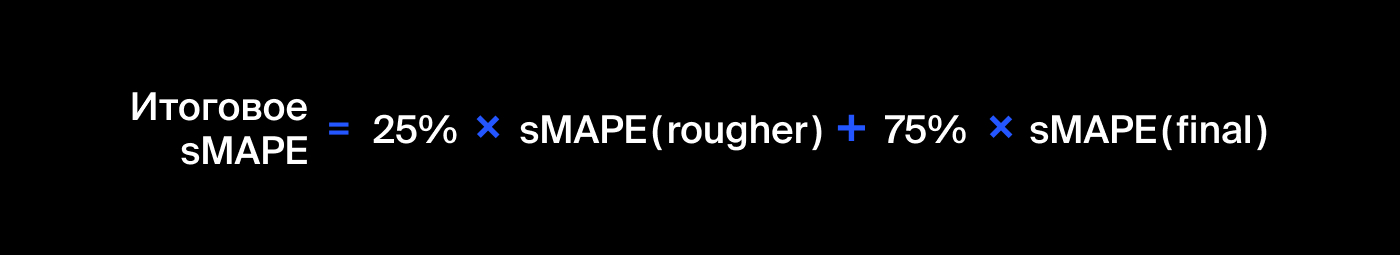

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer

### Изучим данные

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')#прочитаем файлы
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
display(data_train.head())#выведим 5 строк.
print(data_train.shape)
display(data_test.head())
print(data_test.shape)
display(data_full.head())
print(data_full.shape)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


(14149, 87)


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


(5290, 53)


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


(19439, 87)


In [3]:
data_train.info()#изучим тип данных в обучающей выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
data_test.info()#изучим тип данных в тестовой выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [5]:
data_full.info()#изучим тип данных в тестовой выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


__Выводы:____Нам даны три файла с данными о добычи золота. Данные разделены на обучающую выборку, которые содержат 86 столбцов, в том числе целевые признаки эффективности обогощения, также дана тестовая выборка, содержащая 52 столбца, в которой нет целевых признаков, также нама дана полная выборка, содержащая 86 столбцов, в которой содежатся в том числе целевые признаки. Каждый датасет имеет один общий признак дату, который является идентификатором. Все столбцы численные, кроме даты, значит задача регрессии.

### Сравним эффективность обогощения

In [6]:
F = data_train['rougher.input.feed_au']#доля золота в сырье/концентрате до флотации/очистки
C = data_train['rougher.output.concentrate_au']#доля золота в концентрате после флотации/очистки
T = data_train['rougher.output.tail_au']#доля золота в отвальных хвостах после флотации/очитски
data_train['recovery'] = ( (C * (F-T)) / (F * (C-T)) ) * 100 #эффективность обогощения
print(data_train['recovery'].head()) #создадим столбец для расчета recovery

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: recovery, dtype: float64


In [7]:
data_train['rougher.output.recovery'] #выведим исходный recovery который нам дан
print(data_train['rougher.output.recovery'].head())#выведим 5 строк исходного столбца

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64


In [8]:
print('MAE на обучающей выборке эффективности обогощения:', int(mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery'])))
#рассчитаем MAE

MAE на обучающей выборке эффективности обогощения: 0


___Вывод:___ Эффективность обогощения рассчитана правильно, рассчеты совпадают. Мы расчитали MAE для целевого признака, абсолютное отклонение на 0 %, ошибок нет.

### Признаки недоступные в тестовой выборке

In [9]:
print(Counter(data_train).keys())#выведим с помощью keys наименование столбцов
print('---------')
print("Количество столбцов в data_train:", len(Counter(data_train).keys()))#посчитаем количество столбцов

dict_keys(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol', 'final.output.tail_au', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_

In [10]:
print(Counter(data_test).keys())#выведим наименование столбцов
print('---------')
print("Количество столбцов в data_test:", len(Counter(data_test).keys()))#посчитаем количество столбцов

dict_keys(['date', 'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.

In [11]:
print((data_train.loc[:, ~data_train.columns.isin(data_test.columns)]).columns.values)#логическим оператором выберим столбцы, которые не входят в тестовую выборку

['final.output.concentrate_ag' 'final.output.concentrate_pb'
 'final.output.concentrate_sol' 'final.output.concentrate_au'
 'final.output.recovery' 'final.output.tail_ag' 'final.output.tail_pb'
 'final.output.tail_sol' 'final.output.tail_au'
 'primary_cleaner.output.concentrate_ag'
 'primary_cleaner.output.concentrate_pb'
 'primary_cleaner.output.concentrate_sol'
 'primary_cleaner.output.concentrate_au' 'primary_cleaner.output.tail_ag'
 'primary_cleaner.output.tail_pb' 'primary_cleaner.output.tail_sol'
 'primary_cleaner.output.tail_au'
 'rougher.calculation.sulfate_to_au_concentrate'
 'rougher.calculation.floatbank10_sulfate_to_au_feed'
 'rougher.calculation.floatbank11_sulfate_to_au_feed'
 'rougher.calculation.au_pb_ratio' 'rougher.output.concentrate_ag'
 'rougher.output.concentrate_pb' 'rougher.output.concentrate_sol'
 'rougher.output.concentrate_au' 'rougher.output.recovery'
 'rougher.output.tail_ag' 'rougher.output.tail_pb'
 'rougher.output.tail_sol' 'rougher.output.tail_au'
 'seco

In [12]:
data_train = data_train.drop(columns = ['final.output.concentrate_ag', 'final.output.concentrate_pb',
 'final.output.concentrate_sol', 'final.output.concentrate_au', 
 'final.output.tail_ag', 'final.output.tail_pb',
 'final.output.tail_sol', 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag', 'rougher.output.tail_pb',
 'rougher.output.tail_sol', 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au', 'recovery'], axis =1)#удалим признаки, котрые различаются от тестовой выборки, кроме целевых признаков эффективности обогощения, которые были даны

__Вывод:__ Мы проанализировали признаки, недоступные в тестовой выборке. Это этапы технологического процесса, которые есть в обучающей выборке, но нет в тестовой, мы обнаружили что это выходные (output) и расчетные (calculation) характеристики. Следовательно, мы их использовать не будем, так как они не должны быть доступны к началу производства.

### Предобработка данных

#### Обработаем пропуски

In [13]:
data_train.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')
#посчитаем в процентах количество пропусков

,0
date,0.00%
final.output.recovery,0.00%
rougher.output.recovery,0.00%
primary_cleaner.input.feed_size,0.00%
rougher.state.floatbank10_d_air,0.00%
rougher.state.floatbank10_d_level,0.00%
rougher.input.feed_au,0.00%
rougher.state.floatbank10_e_level,0.00%
rougher.state.floatbank10_f_air,0.00%
rougher.state.floatbank10_f_level,0.00%


In [14]:
data_test.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
date,0.00%
rougher.state.floatbank10_c_air,0.00%
rougher.state.floatbank10_c_level,0.00%
rougher.state.floatbank10_d_air,0.00%
rougher.state.floatbank10_d_level,0.00%
rougher.state.floatbank10_e_air,0.00%
rougher.state.floatbank10_e_level,0.00%
rougher.state.floatbank10_f_air,0.00%
rougher.state.floatbank10_f_level,0.00%
secondary_cleaner.state.floatbank2_a_level,0.00%


In [15]:
data_full.isna().mean().round(4).to_frame().sort_values(by=0).style.format('{:.2%}').background_gradient('coolwarm')

,0
date,0.00%
rougher.output.concentrate_pb,0.00%
rougher.state.floatbank10_f_level,0.00%
rougher.state.floatbank10_f_air,0.00%
rougher.state.floatbank10_e_level,0.00%
rougher.state.floatbank10_d_level,0.00%
rougher.state.floatbank10_d_air,0.00%
secondary_cleaner.output.tail_au,0.00%
rougher.calculation.au_pb_ratio,0.00%
rougher.output.tail_au,0.00%


In [16]:
data_train = data_train.interpolate(method='linear', axis=0).ffill().bfill() #заполним пропуски
data_train.isnull().sum()#проверим наличие пропусков суммой

date                                          0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate       

In [17]:
data_test = data_test.fillna(method='ffill')
data_test.isnull().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [18]:
data_full = data_full.fillna(method='ffill')
data_full.isnull().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

___Комментарии:___ После заполнения пропусков, соединим целевые признаки из полной выборке по дате в тестовую выборку

In [19]:
data_test = data_test.merge(data_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')
#методом merge соединим данные из полной выборки целевые признаки по дате

In [20]:
data_train = data_train.drop(['date'], axis=1)#удалим столбец дату из обучающей и тестовой выборке, чтобы она не мешала строить модель
data_test = data_test.drop(['date'], axis=1)

___Выводы:___ Мы обработали пропуски во всех датафреймах. В обучающей выборке, пропусков на этапе флотационной установки было больше всего 3%. В тестовой выборке больше всего пропусков было 0,5% на этапе флотационной установки и 0,4% на этапе флотации по ингредиенту sol. В полной выборке на этапе вторичной обрабротке по ингредиенту sol было больше всего пропусков 9%. Все пропуски мы заполнили значениями предыдущих значений вдоль строк. Мы добавили в тестовую выборку целевые показатели из полной выборки по дате, затем удалили из тестовой и обучающей выборке дату, чтобы далее она не мешала построению модели.

## Проанализируем данные

### Посмотрим как меняется концентрация металлов на этапах очистки

In [21]:
print('Концентрация металлов перед флотацией')
print('Концентрация металла золота:', '{:8.3f}'.format(data_full['rougher.input.feed_au'].mean()))#посчитаем среднее столбца
print('Концентрация металла серебра:', '{:8.3f}'.format(data_full['rougher.input.feed_ag'].mean()))#используем format для округления
print('Концентрация металла свинца:', '{:8.3f}'.format(data_full['rougher.input.feed_pb'].mean()))

Концентрация металлов перед флотацией
Концентрация металла золота:    8.266
Концентрация металла серебра:    8.795
Концентрация металла свинца:    3.585


In [22]:
print('Концентрация металлов после флотации')
print('Концентрация металла золота:', '{:8.3f}'.format(data_full['rougher.output.concentrate_au'].mean()))
print('Концентрация металла серебра:', '{:8.3f}'.format(data_full['rougher.output.concentrate_ag'].mean()))
print('Концентрация металла свинца:', '{:8.3f}'.format(data_full['rougher.output.concentrate_pb'].mean()))

Концентрация металлов после флотации
Концентрация металла золота:   19.772
Концентрация металла серебра:   11.995
Концентрация металла свинца:    7.606


In [23]:
print('Концентрация металлов после первого этапа очистки')
print('Концентрация металла золота:', '{:8.3f}'.format(data_full['primary_cleaner.output.concentrate_au'].mean()))
print('Концентрация металла серебра:', '{:8.3f}'.format(data_full['primary_cleaner.output.concentrate_ag'].mean()))
print('Концентрация металла свинца:', '{:8.3f}'.format(data_full['primary_cleaner.output.concentrate_pb'].mean()))

Концентрация металлов после первого этапа очистки
Концентрация металла золота:   32.119
Концентрация металла серебра:    8.442
Концентрация металла свинца:    9.810


In [24]:
print('Концентрация металлов после второго этапа очистки')
print('Концентрация металла золота:', '{:8.3f}'.format(data_full['final.output.concentrate_au'].mean()))
print('Концентрация металла серебра:', '{:8.3f}'.format(data_full['final.output.concentrate_ag'].mean()))
print('Концентрация металла свинца:', '{:8.3f}'.format(data_full['final.output.concentrate_pb'].mean()))

Концентрация металлов после второго этапа очистки
Концентрация металла золота:   44.077
Концентрация металла серебра:    5.168
Концентрация металла свинца:    9.979


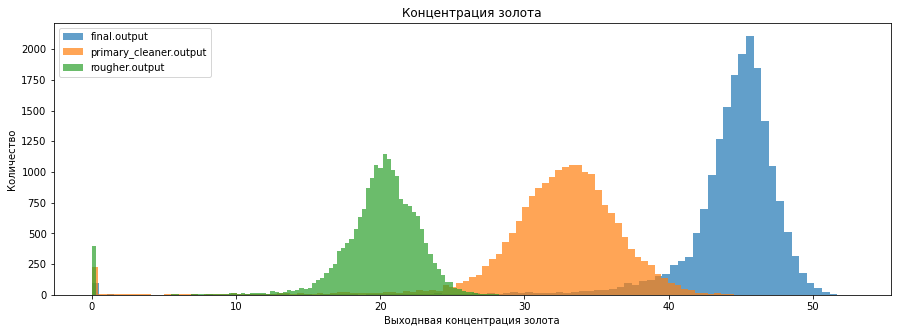

In [25]:
plt.figure(figsize=[15,5])
plt.title('Концентрация золота')
plt.hist(data_full['final.output.concentrate_au'], bins = 100, label='final.output', alpha=0.7)
plt.hist(data_full['primary_cleaner.output.concentrate_au'], bins = 100, label='primary_cleaner.output', alpha=0.7)
plt.hist(data_full['rougher.output.concentrate_au'], bins = 100, label='rougher.output', alpha=0.7)
plt.xlabel('Выходнвая концентрация золота')
plt.ylabel('Количество')
plt.legend(loc='upper left')
plt.show()

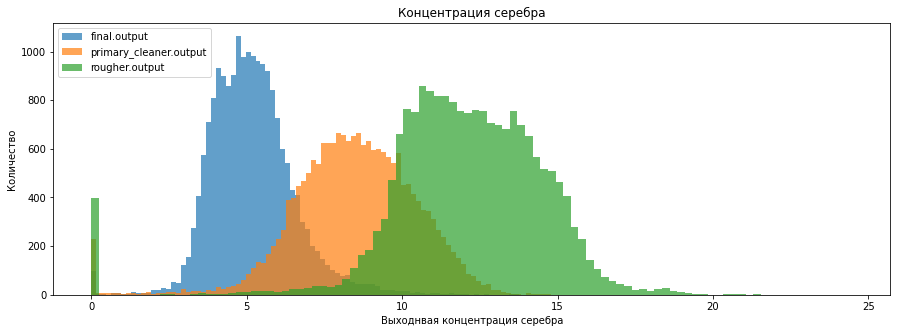

In [26]:
plt.figure(figsize=[15,5])
plt.title('Концентрация серебра')
plt.hist(data_full['final.output.concentrate_ag'], bins = 100, label='final.output', alpha=0.7)
plt.hist(data_full['primary_cleaner.output.concentrate_ag'], bins = 100, label='primary_cleaner.output', alpha=0.7)
plt.hist(data_full['rougher.output.concentrate_ag'], bins = 100, label='rougher.output', alpha=0.7)
plt.xlabel('Выходнвая концентрация серебра')
plt.ylabel('Количество')
plt.legend(loc='upper left')
plt.show()

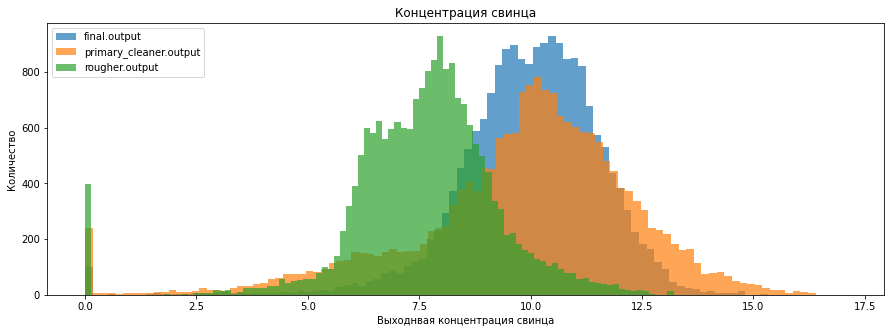

In [27]:
plt.figure(figsize=[15,5])
plt.title('Концентрация свинца')
plt.hist(data_full['final.output.concentrate_pb'], bins = 100, label='final.output', alpha=0.7)
plt.hist(data_full['primary_cleaner.output.concentrate_pb'], bins = 100, label='primary_cleaner.output', alpha=0.7)
plt.hist(data_full['rougher.output.concentrate_pb'], bins = 100, label='rougher.output', alpha=0.7)
plt.xlabel('Выходнвая концентрация свинца')
plt.ylabel('Количество')
plt.legend(loc='upper left')
plt.show()

___Вывод:___ После каждого этапа обработки руды, концентрация металлов увеличивается, золото и свинец. Показатели серебра уменьшились на последнем этапе.

### Распределение размеров гранул сырья

In [28]:
print('Средний размер гранул сырья на обучающей выборке:', '{:8.3f}'.format(data_train['rougher.input.feed_size'].mean()))
#посчитаем средний размер гранул на обучающей выборке, выбрав столбец и расчитав среднее
print('Средний размер гранул сырья на тестовой выборке:', '{:8.3f}'.format(data_test['rougher.input.feed_size'].mean()))

Средний размер гранул сырья на обучающей выборке:   60.098
Средний размер гранул сырья на тестовой выборке:   55.953


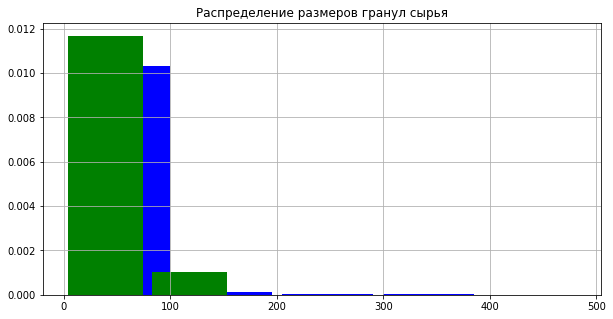

In [29]:
plt.figure(figsize=(10,5))#зададим размер графику
data_train['rougher.input.feed_size'].hist(bins= 5, rwidth= .9, color='blue', label="50% Equities", linewidth=0, density=True)\
    .set_title('Распределение размеров гранул сырья')
data_test['rougher.input.feed_size'].hist(bins= 5, rwidth= .9, color='green', label="50% Equities", linewidth=0, density=True);

___Вывод:___ Средний размер гранул сырья на обучающей и тестовой выборках различается в среднем, но не намного, на 44 единицы. По графику мы видим распределение в обучающей выборке, размер гранул был больше, большой пик на отметке 1800, на тестовой выборке 1250. Отсюда следует, что оценка модели будет немного отличаться.

### Суммарная концентрация всех веществ на разных стадиях

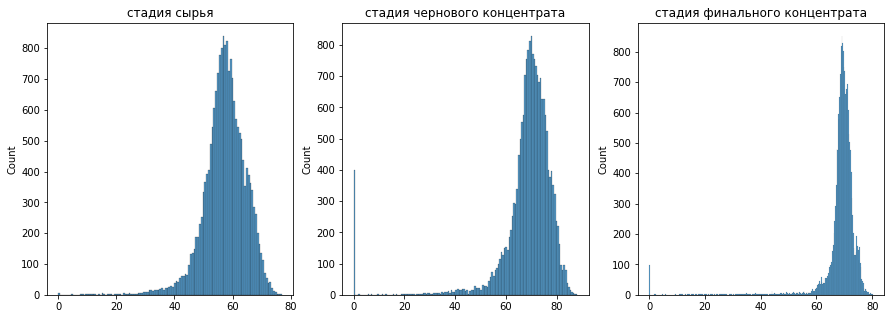

In [30]:
total_concentration = [('rougher.input.feed_', 'стадия сырья'), ('rougher.output.concentrate_', 'стадия чернового концентрата'),\
    ('final.output.concentrate_', 'стадия финального концентрата')]#сделаем список стадий ссумарного концентрата

fig, axs = plt.subplots(1, len(total_concentration), figsize=(15, 5))#построим гисторамму
for i, ax in zip(total_concentration, axs):#создадим цикл
    ax.set_title(i[1])
    sum_total = data_full[i[0]+ 'ag'] + data_full[i[0]+ 'au'] + data_full[i[0]+ 'pb'] + data_full[i[0]+ 'sol']#сложим вещества в список
    sns.histplot(sum_total, ax=ax)
plt.show()

In [31]:
q_low = data_train["rougher.input.feed_ag"].quantile(0.01)#сделаем срез по квантилиям
q_hi  = data_train["rougher.input.feed_ag"].quantile(0.99)
data_train = data_train[(data_train["rougher.input.feed_ag"] < q_hi) & (data_train["rougher.input.feed_ag"] > q_low)]#перепишем датафрейм

In [32]:
q_low_t = data_test["rougher.input.feed_ag"].quantile(0.01)
q_hi_t  = data_test["rougher.input.feed_ag"].quantile(0.99)
data_test = data_test[(data_test["rougher.input.feed_ag"] < q_hi_t) & (data_test["rougher.input.feed_ag"] > q_low_t)]

In [33]:
q_low = data_train["rougher.input.feed_au"].quantile(0.01)#сделаем срез по квантилиям
q_hi  = data_train["rougher.input.feed_au"].quantile(0.99)
data_train = data_train[(data_train["rougher.input.feed_au"] < q_hi) & (data_train["rougher.input.feed_au"] > q_low)]

In [34]:
q_low_t = data_test["rougher.input.feed_au"].quantile(0.01)
q_hi_t  = data_test["rougher.input.feed_au"].quantile(0.99)
data_test = data_test[(data_test["rougher.input.feed_au"] < q_hi_t) & (data_test["rougher.input.feed_au"] > q_low_t)]

In [35]:
q_low = data_train["rougher.input.feed_pb"].quantile(0.01)#сделаем срез по квантилиям
q_hi  = data_train["rougher.input.feed_pb"].quantile(0.99)
data_train = data_train[(data_train["rougher.input.feed_pb"] < q_hi) & (data_train["rougher.input.feed_pb"] > q_low)]

In [36]:
q_low_t = data_test["rougher.input.feed_pb"].quantile(0.01)
q_hi_t  = data_test["rougher.input.feed_pb"].quantile(0.99)
data_test = data_test[(data_test["rougher.input.feed_pb"] < q_hi_t) & (data_test["rougher.input.feed_pb"] > q_low_t)]

In [37]:
q_low = data_train["rougher.input.feed_sol"].quantile(0.01)#сделаем срез по квантилиям
q_hi  = data_train["rougher.input.feed_sol"].quantile(0.99)
data_train = data_train[(data_train["rougher.input.feed_sol"] < q_hi) & (data_train["rougher.input.feed_sol"] > q_low)]

In [38]:
q_low_t = data_test["rougher.input.feed_sol"].quantile(0.01)
q_hi_t  = data_test["rougher.input.feed_sol"].quantile(0.99)
data_test = data_test[(data_test["rougher.input.feed_sol"] < q_hi_t) & (data_test["rougher.input.feed_sol"] > q_low_t)]

__Вывод:__ По распределению гранул на разных стадиях мы увидели, что с каждей стадией гранулы уменьшаются, но также мы заметили некоторые выбросы, поэтому сделали срез по квантилиям на тестовой и обучающей выборке и обрезали выбросы для построения лучшей модели.

## Построим модель

### Функция для вычисления итоговой sMAPE

In [39]:
def calculate_smape(target, predictions):#функция для sMAPE
    numerator = np.abs(target - predictions)
    denominator = (np.abs(target) + np.abs(predictions)) / 2 

    return 1 / len(target) * np.sum(numerator / denominator) * 100
score = make_scorer(calculate_smape, greater_is_better = False)

In [40]:
def final_smape(rougher, final):#функция для итгового sMAPE
    return (0.25*rougher + 0.75*final)

### Обучим разные модели и оценим их качество кросс-валидацией

#### Для прогноза двух величин выделим признаки

In [41]:
target_train_rougher = data_train['rougher.output.recovery']#выделим целевой признак эффект обогощения чернового концентрата
features_train_rougher = data_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)#выделим признаки
target_final_train = data_train['final.output.recovery']#выделим целевой признак эффект обогощения финального концентрата
features_test_rougher = data_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test_rougher = data_test['rougher.output.recovery']
target_final_test = data_test['final.output.recovery']
print(features_train_rougher.shape)#напечаем количество целевых и признаков
print(target_train_rougher.shape)
print(target_final_train.shape)
print(features_test_rougher.shape)
print(target_test_rougher.shape)
print(target_final_test.shape)

(13047, 52)
(13047,)
(13047,)
(4878, 52)
(4878,)
(4878,)


#### Кросс-валидация для лучшей модели

In [42]:
model_1 = LinearRegression()#линейная регрессия
model_2 = RandomForestRegressor()#случайный лес
model_3 = DecisionTreeRegressor()#регрессор дерева решений

In [43]:
model_1.fit(features_train_rougher, target_train_rougher)
scores_1 = cross_val_score(model_1, features_train_rougher, target_train_rougher, cv=5, scoring = score)
rougher_score_1 = scores_1.mean()
scores_1_2 = cross_val_score(model_1, features_train_rougher, target_final_train, cv=5, scoring = score)
final_score_1 = scores_1_2.mean()
print('Оценка чернового концентрата sMAPE на кроссвалидации для LinearRegression: {}'. format(-rougher_score_1))
print('Оценка финального концентрата sMAPE на кроссвалидации для LinearRegression: {}'. format(-final_score_1))

Оценка чернового концентрата sMAPE на кроссвалидации для LinearRegression: 12.876817709128014
Оценка финального концентрата sMAPE на кроссвалидации для LinearRegression: 12.12209468507037


In [44]:
model_2.fit(features_train_rougher, target_train_rougher)
scores_2 = cross_val_score(model_2, features_train_rougher, target_train_rougher, cv=5, scoring = score)
rougher_score_2 = scores_2.mean()
scores_2_2 = cross_val_score(model_2, features_train_rougher, target_final_train, cv=5, scoring = score)
final_score_2 = scores_2_2.mean()
print('Оценка чернового концентрата sMAPE на кроссвалидации для RandomForestRegressor: {}'. format(-rougher_score_2))
print('Оценка финального концентрата sMAPE на кроссвалидации для RandomForestRegressor: {}'. format(-final_score_2))

Оценка чернового концентрата sMAPE на кроссвалидации для RandomForestRegressor: 13.706421164628953
Оценка финального концентрата sMAPE на кроссвалидации для RandomForestRegressor: 10.59352442912018


In [45]:
model_3.fit(features_train_rougher, target_train_rougher)
scores_3 = cross_val_score(model_3, features_train_rougher, target_train_rougher, cv=5, scoring = score)
rougher_score_3 = scores_3.mean()
scores_3_3 = cross_val_score(model_3, features_train_rougher, target_final_train, cv=5, scoring = score)
final_score_3 = scores_3_3.mean()
print('Оценка чернового концентрата sMAPE на кроссвалидации для DecisionTreeRegressor: {}'. format(-rougher_score_3))
print('Оценка финального концентрата sMAPE на кроссвалидации для DecisionTreeRegressor: {}'. format(-final_score_3))

Оценка чернового концентрата sMAPE на кроссвалидации для DecisionTreeRegressor: 18.774657861926535
Оценка финального концентрата sMAPE на кроссвалидации для DecisionTreeRegressor: 19.523518828388816


__Вывод:__ По итогам кроссвалидации и проверке трех моделей, мы выбираем наименьшую sMAPE 12,8 для чернового концентрата и 10,9 для финального концентрата случайного леса.

#### Обучение модели

In [46]:
%%time
param = {
        'n_estimators':range(80,200,4),
        'max_depth':range(2,15,1)
        } #зададим параметры

#расчитаем для rougher и final
grid = RandomizedSearchCV(model_2, param, scoring = score, cv = 3)
grid_rougher = grid.fit(features_train_rougher, target_train_rougher)

grid = RandomizedSearchCV(model_2, param, scoring = score, cv = 3)
grid_final = grid.fit(features_train_rougher, target_final_train)

#посчитаем итоговое smape
result_smape = final_smape(grid_rougher.best_score_, grid_final.best_score_)

print('Лучший sMAPE rougher:', grid_rougher.best_score_, 'при', grid.best_params_)
print('Лучший sMAPE final:', grid_final.best_score_, 'при', grid.best_params_)
print('Филаный sMAPE:', result_smape)

Лучший sMAPE rougher: -11.461264122470434 при {'n_estimators': 92, 'max_depth': 2}
Лучший sMAPE final: -10.370758898798131 при {'n_estimators': 92, 'max_depth': 2}
Филаный sMAPE: -10.643385204716207
CPU times: user 24min 57s, sys: 3.4 s, total: 25min 1s
Wall time: 25min 2s


___Комментарии:__ Итоговой sMAPE случайного леса на обучающей выборке 11

In [47]:
#предскажем на тестовой выборке rougher и final
rougher_test = grid_rougher.predict(features_test_rougher)
final_test = grid_final.predict(features_test_rougher)

In [48]:
rougher_smape_test_k = calculate_smape(target_test_rougher, rougher_test)#рассчитаем smape для предсказаний rougher
final_smape_test_k = calculate_smape(target_final_test, final_test)
final_finish_smape_test_k = final_smape(rougher_smape_test_k, final_smape_test_k)#расчитаем итоговое smape по функции
print('Итоговая ошибка по предсказаниям на тестовой выборке sMAPE', final_finish_smape_test_k)

Итоговая ошибка по предсказаниям на тестовой выборке sMAPE 8.801236810967374


### Сравнение с константной моделью

In [49]:
rougher_dummy_median = DummyRegressor(strategy = 'median').fit(features_train_rougher, target_train_rougher)
#выберим стратегию расчета по медиане и обучим на обучающей модели rougher
final_dummy_median = DummyRegressor(strategy = 'median').fit(features_train_rougher, target_final_train)
rougher_predict_dummy_median = rougher_dummy_median.predict(features_test_rougher)
#предскажем модель на тестовой выборке
final_predict_dummy_median = final_dummy_median.predict(features_test_rougher)

In [50]:
rougher_smape_test = calculate_smape(target_test_rougher, rougher_predict_dummy_median)#рассчитаем smape для предсказаний rougher
final_smape_test = calculate_smape(target_final_test, final_predict_dummy_median)
final_finish_smape_test = final_smape(rougher_smape_test, final_smape_test)#расчитаем итоговое smape по функции
print('Итоговая ошибка по предсказаниям на тестовой выборке sMAPE Dummy:', final_finish_smape_test)

Итоговая ошибка по предсказаниям на тестовой выборке sMAPE Dummy: 8.882919794166526


___Вывод:___ Мы исследовали датасеты, на которых построили модель, которая поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. Для этого мы проанализировали данные концентрации металлов и выяснили, что после каждого этапа концентрация метталов свинца и золота увеличивались, а серебра уменьшались. Затем мы визуализировали данные по размеру гранул и обнаружили, что с каждей стадией они изменялись в меньшую сторону. Затем мы с помощью кросс-валидации выбрали наилучшую модель Случайный лес и сделали предсказания, чтобы посчитать итоговое smape. Итоговая sMAPE на тестовой выборке 9,08, по сравнению с константной моделью 8,88, мы сделали вывод что модель приемлема.